# Creating a lazy-loading reaction.

Imports.

In [29]:
import rdkit
from dgym.molecule import Molecule
from typing import Optional, List, Union, Any
import itertools
from rdkit.Chem.rdChemReactions import ChemicalReaction
from rdkit import Chem
import random
import dgym as dg

Defining LazyReaction.

In [529]:
import inspect

class LazyReaction:
    
    def __init__(
        self,
        template: Union[str, ChemicalReaction],
        metadata: Optional[dict] = None,
        id: Optional[str] = None
    ) -> None:
        """
        Parameters
        ----------
        template : rdkit.Chem.rdChemReactions.ChemicalReaction
            An rdkit reaction template.
        """
        if isinstance(template, str):
            template = rdkit.Chem.AllChem.ReactionFromSmarts(template)

        self.id = id
        self.template = template
        self.products = list(template.GetProducts())
        self.agents = list(template.GetAgents())
        self.reactants = list(template.GetReactants())
        self.metadata = metadata
    
    def run(self, reagents, sanitize=True):
        
        # If any of the reagents are generators
        if any(inspect.isgenerator(r) for r in reagents):
            
            # Convert ordinary reagents to infinite generators
            sequences = [
                itertools.repeat(x)
                if not inspect.isgenerator(x) else x
                for x in reagents
            ]

            # Run reactants lazily
            for combination in zip(*sequences):
                yield from self.run_single_step(combination, sanitize)
        
        else:
            yield from self.run_single_step(reagents, sanitize)
        
    def run_single_step(self, reagents, sanitize=True):
        mols = [r.mol if isinstance(r, Molecule) else r for r in reagents]
        output = self.template.RunReactants(mols)
        yield from self.parse_output(output, reagents, sanitize = sanitize)
        
    def parse_output(self, output, reactants, sanitize=True):
        output = self.flatten_and_randomize(output)
        cache = set()
        for product in output:
            if product := self.sanitize(product):
                yield Molecule(product, reaction = self, reactants = reactants)
            else:
                continue

    @staticmethod
    def flatten_and_randomize(nested_tuples, randomize=True):
        flattened_items = []
        for item in nested_tuples:
            if isinstance(item, tuple):
                flattened_items.extend(item)
            else:
                flattened_items.append(item)

        random.shuffle(flattened_items)
        for item in flattened_items:
            yield item
        
    def sanitize(self, mol):
        smiles = Chem.MolToSmiles(mol)
        product = Chem.MolFromSmiles(smiles)
        return product
    
    def _repr_png_(self):
        return self.template._repr_png_()
    
    def is_compatible(self, product = None, reactants = None):
        
        # Use reactants from product if none provided
        if reactants is None:
            reactants = product.reactants

        # If neither product nor reactant are provided
        if not product and not reactants:
            return False

        # If the length of reactants matches
        if len(reactants) != len(self.reactants):
            return False
        
        # If the identity of products match
        for reactant_order in itertools.permutations(reactants):
            if output := self.run(reactant_order):
                if not product:
                    return True
                elif product:
                    return any(
                        product.smiles == o.smiles
                        for o in output
                    )

        return False

Importing the actual data structures.

In [530]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)
reactions = dg.collection.ReactionCollection([LazyReaction(r.template, id=r.id) for r in reactions])

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

load data


Defining multi step molecule test-cases.

In [531]:
multi_step_molecule = Molecule(
    'O=C(c1ccnnc1)N(c1ccc2ncccc2c1)c1cnn(-c2c(Cl)cc(C(F)(C(F)(F)F)C(F)(F)F)cc2Cl)c1',
    reaction = reactions['18_Halide_and_Amine'][0],
    reactants = [
        Molecule('FC(F)(F)C(F)(c1cc(Cl)c(-n2cc(I)cn2)c(Cl)c1)C(F)(F)F'),
        Molecule('O=C(Nc1ccc2ncccc2c1)c1ccnnc1',
                 reaction = reactions['13_Carboxylate_and_Amine'][0],
                 reactants = [Molecule('O=C(O)c1ccnnc1'), Molecule('Nc1ccc2ncccc2c1')]
        )
    ]
)

In [532]:
molecule = Molecule(
    'O=C(Nc1ccc2ncccc2c1)c1ccnnc1',
    reaction = reactions['13_Carboxylate_and_Amine'][0],
    reactants = [Molecule('O=C(O)c1ccnnc1'), Molecule('Nc1ccc2ncccc2c1')]
)

r = LazyReaction(reactions['13_Carboxylate_and_Amine'][0].template)

product = r.run(molecule.reactants)

In [533]:
%%time
multi_step_molecule = Molecule(
    'O=C(c1ccnnc1)N(c1ccc2ncccc2c1)c1cnn(-c2c(Cl)cc(C(F)(C(F)(F)F)C(F)(F)F)cc2Cl)c1',
    reaction = reactions['18_Halide_and_Amine'][0],
    reactants = [
        Molecule('FC(F)(F)C(F)(c1cc(Cl)c(-n2cc(I)cn2)c(Cl)c1)C(F)(F)F'),
        product
    ]
)

r = LazyReaction(reactions['18_Halide_and_Amine'][0].template)
output = r.run(multi_step_molecule.reactants)
result = list(output)

CPU times: user 4.33 ms, sys: 758 µs, total: 5.08 ms
Wall time: 5.17 ms


Instantiate the analog generator.

In [542]:
from dgym.envs.library_designer import LibraryDesigner

library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

Demonstration of how to "poise" the generators.

In [543]:
def random_combinations(lst, r, k=100):
    """
    Yields a random combination of r items in list.
    """
    if r == 0:
        yield [], lst

    all_combinations = list(itertools.combinations(lst, r))
    selected_combinations = random.choices(all_combinations, k=k)
    for combo in selected_combinations:
        nonselected_items = tuple(item for item in lst if item not in combo)
        yield combo, nonselected_items

In [552]:
# Create reactant generator
molecule = deck[0]
reactant_generators = library_designer.generate_analogs(molecule.reactants, temperature=0.0)

# Poise
indices = list(range(len(reactant_generators)))
combos = random_combinations(indices, r=1)
constant, variable = next(combos)
constant_reactants = [molecule.reactants[c] for c in constant]
variable_reactants = [next(reactant_generators[v]) for v in variable]
reactants = [*constant_reactants, *variable_reactants]

Learning how to reconstruct a molecule and preserve its reactions.

In [616]:
def reconstruct_molecule(molecule):
    
    if inspect.isgenerator(molecule):
        return molecule
    
    # Base case
    if not molecule.reactants:
        display(molecule)
        return molecule
    
    # Recursive case: Reconstruct each reactant
    reconstructed_reactants = [reconstruct_molecule(reactant)
                               for reactant in molecule.reactants]
    
    # # Find analogs
    # for idx, reactant in enumerate(reconstructed_reactants):
    #     if isinstance(reactant, Molecule):
    #         reconstructed_reactants[idx] = library_designer.generate_analogs(
    #             [reactant], temperature=0.0
    #         )[0]
    
    # Use the reaction to reconstruct the original molecule from its reactants
    output = molecule.reaction.run(reconstructed_reactants)
    return output

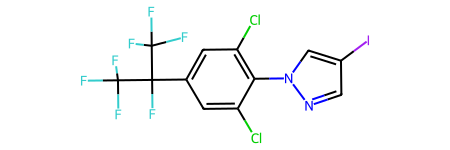

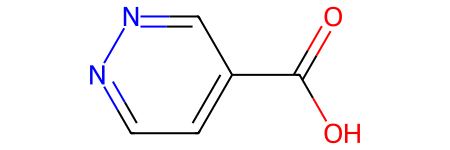

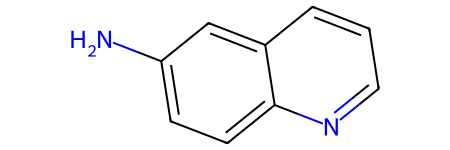

In [617]:
multi_step_molecule = Molecule(
    'O=C(c1ccnnc1)N(c1ccc2ncccc2c1)c1cnn(-c2c(Cl)cc(C(F)(C(F)(F)F)C(F)(F)F)cc2Cl)c1',
    reaction = reactions['18_Halide_and_Amine'][0],
    reactants = [
        Molecule('FC(F)(F)C(F)(c1cc(Cl)c(-n2cc(I)cn2)c(Cl)c1)C(F)(F)F'),
        Molecule('O=C(Nc1ccc2ncccc2c1)c1ccnnc1',
                 reaction = reactions['13_Carboxylate_and_Amine'][0],
                 reactants = [Molecule('O=C(O)c1ccnnc1'), Molecule('Nc1ccc2ncccc2c1')]
        )
    ]
)
generator = reconstruct_molecule(multi_step_molecule)

In [618]:
from copy import deepcopy

copy_molecule = deepcopy(multi_step_molecule)
copy_molecule.reactants[1].reactants[0] = library_designer.generate_analogs([copy_molecule.reactants[1].reactants[0]])[0]

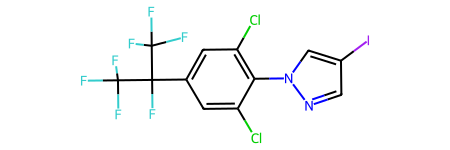

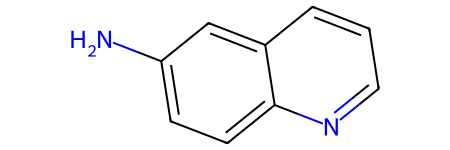

In [619]:
generator = reconstruct_molecule(copy_molecule)

In [638]:
results = next(generator)

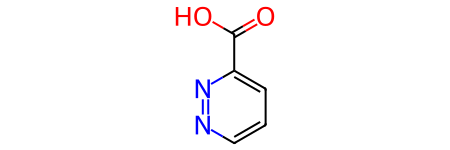

In [646]:
results.reactants[1].reactants[0]